# Explainable AI - SHAP and tree based models

## Libraries (as usual)

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.impute import SimpleImputer

import shap
shap.initjs()

## The path to the dataset

In [3]:
# --------------------------
# 1. Load dataset
# --------------------------
DATA_PATH = "/home/ruima/code/delaunan/clintrialpredict/data"
df = pd.read_csv(os.path.join(DATA_PATH, 'shap_X_test.csv'))

# Clean column names
df.columns = [c.strip() for c in df.columns]

# Check available columns
print("Columns in dataset:", df.columns.tolist())


# --------------------------
# 1b. Create target if not present
# --------------------------
target_col = 'target'
if target_col not in df.columns:
    # Create a random binary target for demonstration
    np.random.seed(42)
    df[target_col] = np.random.randint(0, 2, size=len(df))
    print(f"Column '{target_col}' not found, created random binary target for demo.")

Columns in dataset: ['competition_niche', 'competition_broad', 'num_primary_endpoints', 'number_of_arms', 'criteria_len_log', 'start_year', 'phase_ordinal', 'is_international_1', 'covid_exposure_0', 'healthy_volunteers_No', 'healthy_volunteers_f', 'healthy_volunteers_t', 'adult_t', 'child_t', 'older_adult_t', 'includes_us_1', 'gender_ALL', 'gender_FEMALE', 'gender_MALE', 'gender_UNKNOWN', 'agency_class_FED', 'agency_class_INDIV', 'agency_class_INDUSTRY', 'agency_class_NETWORK', 'agency_class_NIH', 'agency_class_OTHER', 'agency_class_OTHER_GOV', 'agency_class_UNKNOWN', 'masking_DOUBLE', 'masking_NONE', 'masking_QUADRUPLE', 'masking_SINGLE', 'masking_TRIPLE', 'masking_UNKNOWN', 'intervention_model_CROSSOVER', 'intervention_model_FACTORIAL', 'intervention_model_PARALLEL', 'intervention_model_SEQUENTIAL', 'intervention_model_SINGLE_GROUP', 'intervention_model_UNKNOWN', 'primary_purpose_BASIC_SCIENCE', 'primary_purpose_DIAGNOSTIC', 'primary_purpose_ECT', 'primary_purpose_HEALTH_SERVICES_RES

In [4]:
# --------------------------
# 2. Temporal train/test split
# --------------------------
# Sort by start year for temporal split
df = df.sort_values("start_year").reset_index(drop=True)
split_idx = int(len(df) * 0.8)

train_df = df.iloc[:split_idx].copy()
test_df  = df.iloc[split_idx:].copy()

# Drop columns not used as features
drop_cols = [target_col, "overall_status", "nct_id"]
X_train = train_df.drop(columns=[c for c in drop_cols if c in train_df.columns])
y_train = train_df[target_col]
X_test  = test_df.drop(columns=[c for c in drop_cols if c in test_df.columns])
y_test  = test_df[target_col]

In [5]:
# --------------------------
# 3. Dataset statistics
# --------------------------
def print_stats(name, dataset, y):
    n_total = len(dataset)
    n_good = len(dataset[y == 0])
    n_bad  = len(dataset[y == 1])
    pct_good = (n_good / n_total) * 100
    pct_bad  = (n_bad / n_total) * 100
    min_year = dataset['start_year'].min()
    max_year = dataset['start_year'].max()

    print(f"--- {name} SET ---")
    print(f"Time Period: {int(min_year)} to {int(max_year)}")
    print(f"Total Trials: {n_total}")
    print(f"Good (0): {n_good} ({pct_good:.1f}%)")
    print(f"Bad (1): {n_bad} ({pct_bad:.1f}%)\n")

print("="*40)
print("DATASET SPLIT STATISTICS")
print("="*40)
print_stats("OVERALL", df, df[target_col])
print_stats("TRAINING (Past)", train_df, y_train)
print_stats("TESTING (Future)", test_df, y_test)

DATASET SPLIT STATISTICS
--- OVERALL SET ---
Time Period: 2013 to 2015
Total Trials: 13473
Good (0): 6730 (50.0%)
Bad (1): 6743 (50.0%)

--- TRAINING (Past) SET ---
Time Period: 2013 to 2015
Total Trials: 10778
Good (0): 5395 (50.1%)
Bad (1): 5383 (49.9%)

--- TESTING (Future) SET ---
Time Period: 2015 to 2015
Total Trials: 2695
Good (0): 1335 (49.5%)
Bad (1): 1360 (50.5%)



In [6]:
# --------------------------
# 4. Preprocessing pipeline including embeddings + keywords
# --------------------------
def get_pipeline():
    log_trans_cols = ['competition_niche', 'competition_broad',
                      'num_primary_endpoints', 'number_of_arms',
                      'criteria_len_log']
    stand_scal_cols = ["start_year"]
    minmax_scal_cols = ["phase_ordinal"]

    log_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('log', FunctionTransformer(np.log1p)),
        ('scaler', StandardScaler())
    ])
    standard_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    minmax_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('log', log_transformer, log_trans_cols),
            ('std', standard_transformer, stand_scal_cols),
            ('minmax', minmax_transformer, minmax_scal_cols)
        ],
        remainder='passthrough'
    )

    return preprocessor

preprocessor = get_pipeline()

In [7]:
# --------------------------
# 5. Build and train model
# --------------------------

# Redefine get_pipeline to handle all column types including NaNs
def get_pipeline():
    log_trans_cols = ['competition_niche', 'competition_broad',
                      'num_primary_endpoints', 'number_of_arms',
                      'criteria_len_log']
    stand_scal_cols = ["start_year"]
    minmax_scal_cols = ["phase_ordinal"]

    # Columns that are likely categorical strings and should be dropped or one-hot encoded
    # For Logistic Regression, direct string input is not possible, so we'll drop them for now.
    string_categorical_cols = ['therapeutic_subgroup_name', 'best_pathology', 'sponsor_clean']

    # Get all columns from X_train to determine which are 'other numeric'
    # Assuming X_train is available in the global scope from previous cells
    all_columns = X_train.columns.tolist()

    processed_cols_initial = log_trans_cols + stand_scal_cols + minmax_scal_cols + string_categorical_cols
    other_numeric_cols = [col for col in all_columns if col not in processed_cols_initial]

    log_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('log', FunctionTransformer(np.log1p)),
        ('scaler', StandardScaler())
    ])
    standard_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    minmax_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler())
    ])

    # Transformer for other numeric columns (like embeddings, truncatedsvd, binary flags)
    # that also need imputation and scaling
    other_numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('log', log_transformer, log_trans_cols),
            ('std', standard_transformer, stand_scal_cols),
            ('minmax', minmax_transformer, minmax_scal_cols),
            ('other_numeric', other_numeric_transformer, other_numeric_cols), # Handle other numeric columns
            ('drop_strings', 'drop', string_categorical_cols) # Explicitly drop string columns
        ],
        remainder='drop' # Explicitly drop any unhandled columns to avoid errors
    )

    return preprocessor

# Re-instantiate the preprocessor with the corrected function
preprocessor = get_pipeline()

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        class_weight='balanced',
        solver='liblinear',
        penalty='l2',
        C=0.01,
        max_iter=1000,
        random_state=42
    ))
])

print(f"Training Logistic Regression on {len(X_train)} trials...")
model.fit(X_train, y_train)
print("Training Complete.")

Training Logistic Regression on 10778 trials...
Training Complete.


In [8]:
# --------------------------
# 6. Transform Features for SHAP
# --------------------------
X_train_transformed = model.named_steps['preprocessor'].transform(X_train)
X_test_transformed  = model.named_steps['preprocessor'].transform(X_test)

In [9]:
# --------------------------
# 7. Helper Function to Get Feature Names
# --------------------------
def get_transformed_feature_names(preprocessor, original_columns):
    feature_names = []
    for name, transformer, cols in preprocessor.transformers_:
        if transformer == "drop":
            continue
        if transformer == "passthrough":
            if isinstance(cols, slice):
                cols = original_columns[cols]
            feature_names.extend([str(c) for c in cols])
        else:
            try:
                fn = transformer.get_feature_names_out(cols)
            except:
                fn = cols
            feature_names.extend([str(f) for f in fn])
    # Add remainder columns if any
    if preprocessor.remainder == "passthrough":
        used_cols = []
        for _, _, cols in preprocessor.transformers_:
            if isinstance(cols, slice):
                used_cols.extend(list(original_columns[cols]))
            else:
                used_cols.extend(list(cols))
        remainder_cols = [c for c in original_columns if c not in used_cols]
        feature_names.extend([str(c) for c in remainder_cols])
    return feature_names

transformed_feature_names = get_transformed_feature_names(preprocessor, X_train.columns)

In [10]:
# --------------------------
# 8. Compute SHAP values
# --------------------------
predict_fn = lambda X: model.named_steps['classifier'].predict_proba(X)[:, 1]
explainer = shap.Explainer(predict_fn, X_train_transformed)
shap_values = explainer(X_test_transformed)

# Match number of features
transformed_feature_names_used = transformed_feature_names[:X_test_transformed.shape[1]]

PermutationExplainer explainer: 2696it [12:28,  3.60it/s]                            


In [11]:
# ============================
# 9. Aggregate Embeddings & Keywords
# ============================
shap_df = pd.DataFrame(shap_values.values, columns=transformed_feature_names_used)

emb_cols = [c for c in transformed_feature_names_used if str(c).startswith("emb_")]
kw_cols  = [c for c in transformed_feature_names_used if str(c).startswith("truncatedsvd")]
other_cols = [c for c in transformed_feature_names_used if c not in emb_cols + kw_cols]

shap_df["Embeddings"] = shap_df[emb_cols].abs().sum(axis=1)
shap_df["Keywords"]   = shap_df[kw_cols].abs().sum(axis=1)

shap_agg_df = shap_df[other_cols].copy()
shap_agg_df["Embeddings"] = shap_df["Embeddings"]
shap_agg_df["Keywords"]   = shap_df["Keywords"]

In [12]:
# --------------------------
# 10. Prepare X_test for Plotting
# --------------------------

# FIX: Create proper mapping of all transformed feature names
X_test_plot_full = pd.DataFrame(
    X_test_transformed,
    columns=transformed_feature_names_used
)

# FIX: Keep the original named features (not numeric ones)
# These are the features that passed through without renaming
original_feature_cols = [
    c for c in transformed_feature_names_used
    if not (str(c).startswith("emb_") or str(c).startswith("kw_"))
]

# Build final plotting dataset
X_test_plot = X_test_plot_full[original_feature_cols].copy()

# Add aggregated embedding & keyword features
X_test_plot["Embeddings"] = shap_df["Embeddings"]
X_test_plot["Keywords"]   = shap_df["Keywords"]

In [13]:
# --------------------------
# 001. Check
# --------------------------
# Check available columns
print("Columns in dataset:", df.columns.tolist())

# Check available columns
print("Columns in X_test:", X_test.columns.tolist())

# Check available columns
print("Columns in X_test_plot:", X_test_plot.columns.tolist())

Columns in dataset: ['competition_niche', 'competition_broad', 'num_primary_endpoints', 'number_of_arms', 'criteria_len_log', 'start_year', 'phase_ordinal', 'is_international_1', 'covid_exposure_0', 'healthy_volunteers_No', 'healthy_volunteers_f', 'healthy_volunteers_t', 'adult_t', 'child_t', 'older_adult_t', 'includes_us_1', 'gender_ALL', 'gender_FEMALE', 'gender_MALE', 'gender_UNKNOWN', 'agency_class_FED', 'agency_class_INDIV', 'agency_class_INDUSTRY', 'agency_class_NETWORK', 'agency_class_NIH', 'agency_class_OTHER', 'agency_class_OTHER_GOV', 'agency_class_UNKNOWN', 'masking_DOUBLE', 'masking_NONE', 'masking_QUADRUPLE', 'masking_SINGLE', 'masking_TRIPLE', 'masking_UNKNOWN', 'intervention_model_CROSSOVER', 'intervention_model_FACTORIAL', 'intervention_model_PARALLEL', 'intervention_model_SEQUENTIAL', 'intervention_model_SINGLE_GROUP', 'intervention_model_UNKNOWN', 'primary_purpose_BASIC_SCIENCE', 'primary_purpose_DIAGNOSTIC', 'primary_purpose_ECT', 'primary_purpose_HEALTH_SERVICES_RES

/tmp/ipykernel_48060/1448046884.py:29: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


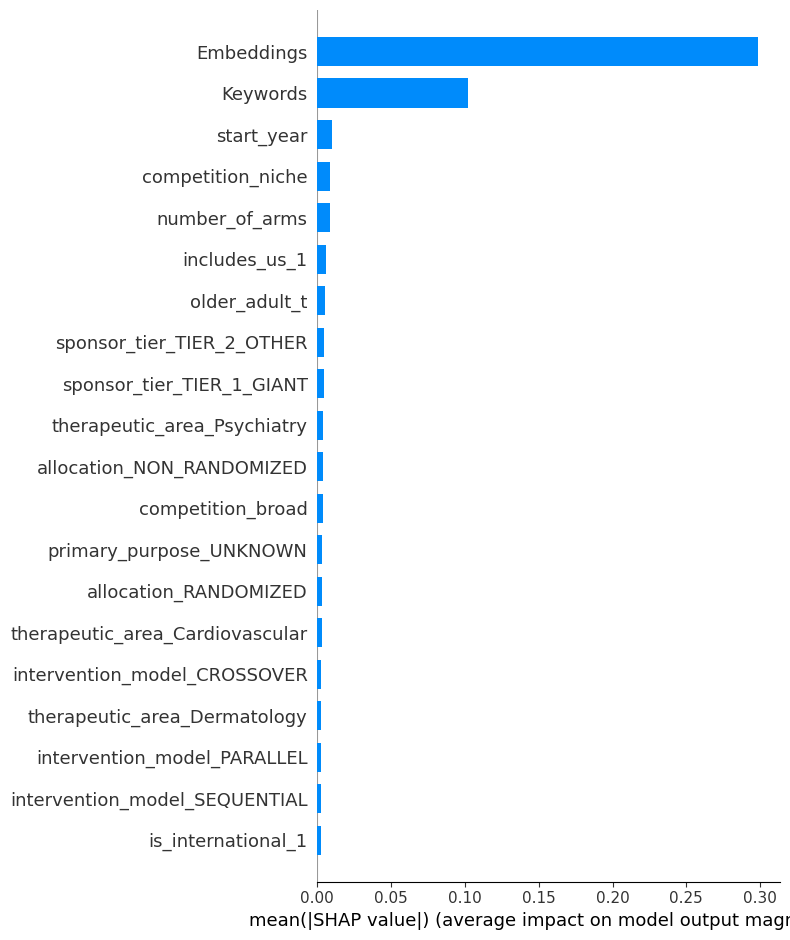

In [14]:
# --------------------------
# 11. Summary plot (aggregated SHAP)
# --------------------------

# The shap_agg_df contains the aggregated SHAP values.
# We need to ensure X_test_plot contains the corresponding aggregated FEATURE values.

# Reconstruct X_test_plot to match the feature aggregation in shap_agg_df
# 1. Get the individual feature values for 'other_cols'
X_test_plot_for_shap = X_test_plot_full[other_cols].copy()

# 2. Aggregate the actual feature values for Embeddings and Keywords
#    For consistency with the SHAP aggregation (sum of absolute values),
#    we can sum the absolute feature values. However, for feature values,
#    a simple sum of the transformed values is usually more appropriate
#    to represent the aggregated feature's overall value, not just magnitude.
#    Let's use simple sum for feature aggregation.
X_test_plot_for_shap["Embeddings"] = X_test_plot_full[emb_cols].sum(axis=1)
X_test_plot_for_shap["Keywords"]   = X_test_plot_full[kw_cols].sum(axis=1)

# Ensure the order of columns in X_test_plot_for_shap matches shap_agg_df's columns
X_test_plot_for_shap = X_test_plot_for_shap[shap_agg_df.columns]

# Now, the shapes should match:
# shap_values: shap_agg_df.values
# features: X_test_plot_for_shap.values
# feature_names: shap_agg_df.columns

shap.summary_plot(
    shap_agg_df.values,
    X_test_plot_for_shap.values,
    feature_names=shap_agg_df.columns,
    plot_type="bar"
)

In [15]:
# --------------------------
# 002. Check
# --------------------------
# Check available columns
print("Columns in dataset:", df.columns.tolist())

# Check available columns
print("Columns in X_test:", X_test.columns.tolist())

# Check available columns
print("Columns in X_test_plot_for_shap:", X_test_plot_for_shap.columns.tolist())

Columns in dataset: ['competition_niche', 'competition_broad', 'num_primary_endpoints', 'number_of_arms', 'criteria_len_log', 'start_year', 'phase_ordinal', 'is_international_1', 'covid_exposure_0', 'healthy_volunteers_No', 'healthy_volunteers_f', 'healthy_volunteers_t', 'adult_t', 'child_t', 'older_adult_t', 'includes_us_1', 'gender_ALL', 'gender_FEMALE', 'gender_MALE', 'gender_UNKNOWN', 'agency_class_FED', 'agency_class_INDIV', 'agency_class_INDUSTRY', 'agency_class_NETWORK', 'agency_class_NIH', 'agency_class_OTHER', 'agency_class_OTHER_GOV', 'agency_class_UNKNOWN', 'masking_DOUBLE', 'masking_NONE', 'masking_QUADRUPLE', 'masking_SINGLE', 'masking_TRIPLE', 'masking_UNKNOWN', 'intervention_model_CROSSOVER', 'intervention_model_FACTORIAL', 'intervention_model_PARALLEL', 'intervention_model_SEQUENTIAL', 'intervention_model_SINGLE_GROUP', 'intervention_model_UNKNOWN', 'primary_purpose_BASIC_SCIENCE', 'primary_purpose_DIAGNOSTIC', 'primary_purpose_ECT', 'primary_purpose_HEALTH_SERVICES_RES

In [20]:
# --------------------------
# 12. Force plot for the top 10 features
# --------------------------

# ---------------------------
# 1. Compute mean SHAP values
# ---------------------------
shap_mean = shap_agg_df.mean(axis=0)  # average per feature

# ---------------------------
# 2. Select top 10 features by absolute importance
# ---------------------------
top_features = shap_mean.abs().sort_values(ascending=False).head(10).index.tolist()
shap_top_values = shap_mean[top_features].values

# ---------------------------
# 3. Create SHAP Explanation object
# ---------------------------
expl = shap.Explanation(
    values = shap_top_values,
    base_values = 0,  # mean model output if you want to scale, adjust here
    data = np.zeros_like(shap_top_values),
    feature_names = top_features
)

# ---------------------------
# 4. Plot the force plot
# ---------------------------
shap.plots.force(expl)

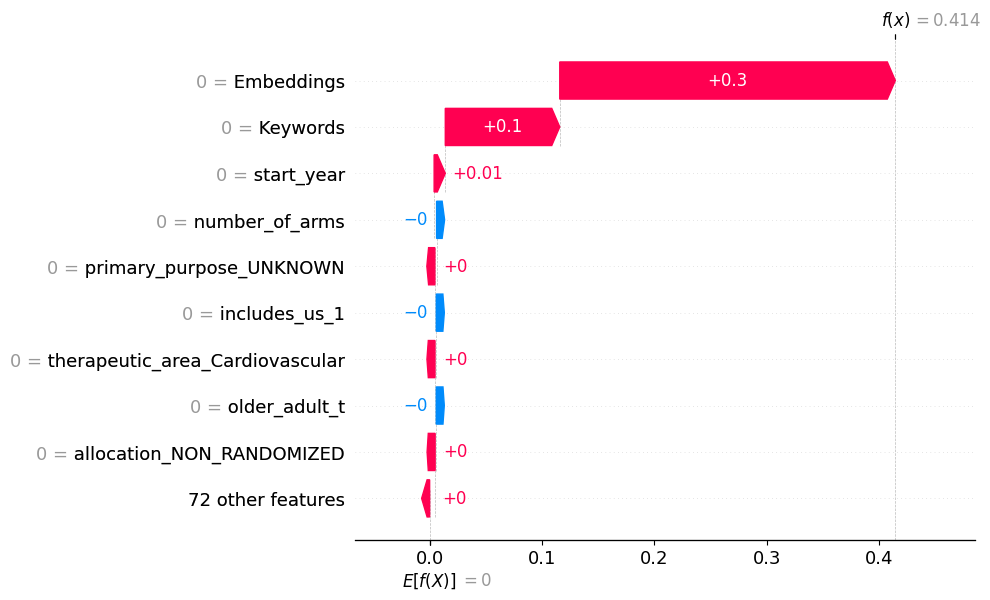

In [74]:
# --------------------------
# 13. Waterfall plot for the average patient
# --------------------------

# ---------------------------
# 1. Compute mean SHAP values per feature
# ---------------------------
shap_mean = shap_agg_df.mean(axis=0)  # average SHAP values for each feature

# ---------------------------
# 2. Create SHAP Explanation object for the "average patient"
# ---------------------------
expl = shap.Explanation(
    values = shap_mean.values,
    base_values = 0,  # optional: can set to mean model output if desired
    data = np.zeros_like(shap_mean.values),
    feature_names = shap_mean.index.tolist()
)

# ---------------------------
# 3. Generate the waterfall plot
# ---------------------------
shap.plots.waterfall(expl)

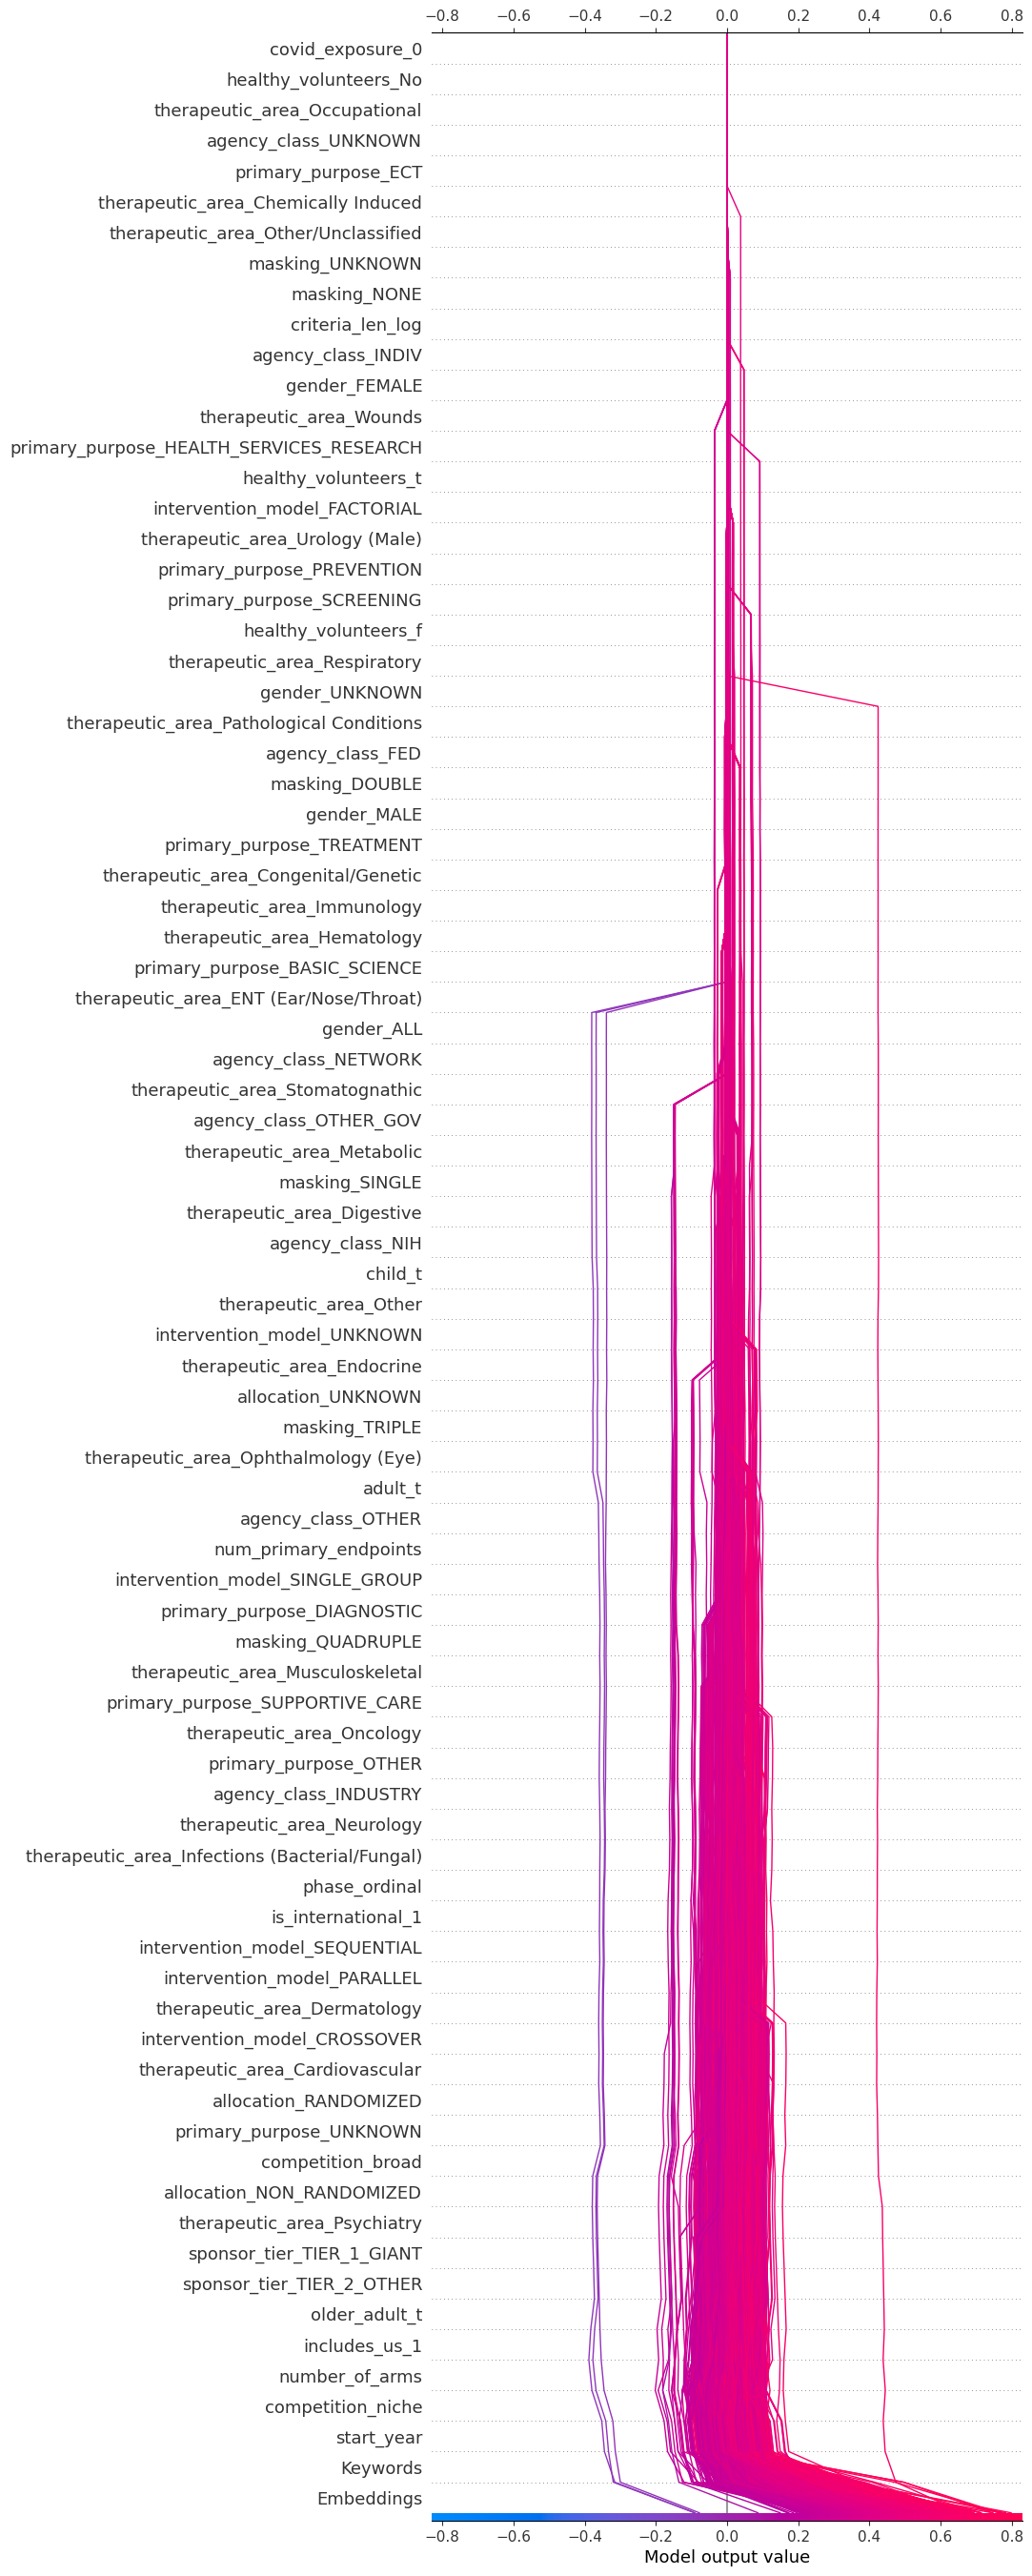

In [87]:
# --------------------------
# 14. Decision plot for the entire dataset
# --------------------------


import shap
import numpy as np

# --------------------------
# 14. Decision plot for the entire dataset
# --------------------------

# Convert aggregated SHAP DataFrame to numpy
shap_vals_array = shap_agg_df.values
X_values_array = X_test_plot_for_shap.values
feature_names_list = shap_agg_df.columns.tolist()

# Use scalar baseline
base_value_scalar = 0.0  # you can also use model mean prediction

# Generate decision plot
shap.decision_plot(
    base_value=base_value_scalar,  # scalar baseline
    shap_values=shap_vals_array,
    features=X_values_array,
    feature_names=feature_names_list,
    feature_display_range=slice(None),
    ignore_warnings=True,
    link='identity'
)

In [69]:
# --------------------------
# 15. Force plot for the average patient
# --------------------------
# Compute the average SHAP values
shap_avg = shap_agg_df.mean(axis=0).values
names    = shap_agg_df.columns.tolist()

# Build the Explanation object
expl = shap.Explanation(
    values      = shap_avg,
    base_values = 0,
    data        = np.zeros_like(shap_avg),
    feature_names = names
)

# Plot the force plot
shap.plots.force(expl)


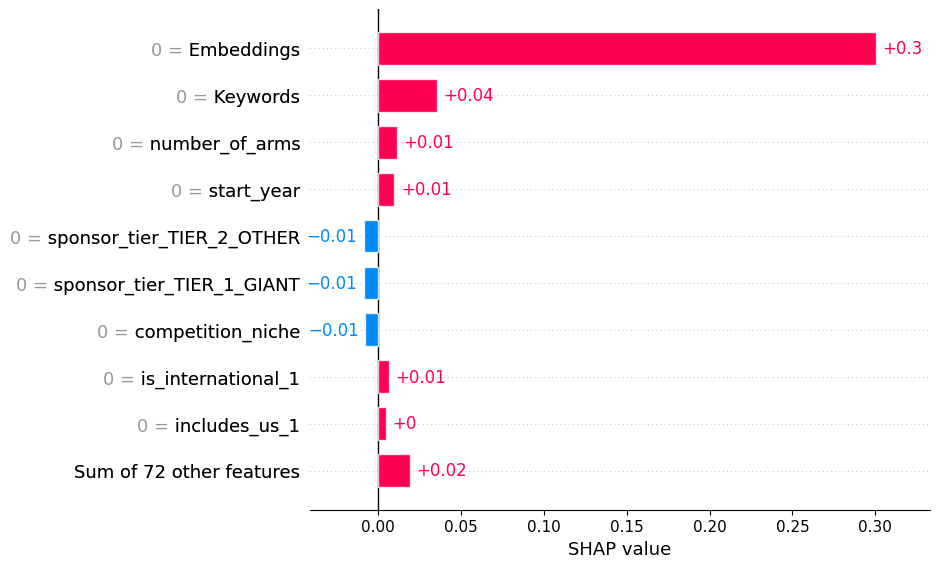

In [68]:
# --------------------------
# 16. Bar plot for the first patient
# --------------------------
# 1) Select sample
values = shap_agg_df.iloc[0].values
names  = shap_agg_df.columns.tolist()

# 2) Build Explanation object
expl = shap.Explanation(
    values=values,
    base_values=0,
    data=np.zeros_like(values),
    feature_names=names
)

# 3) Plot
shap.plots.bar(expl)

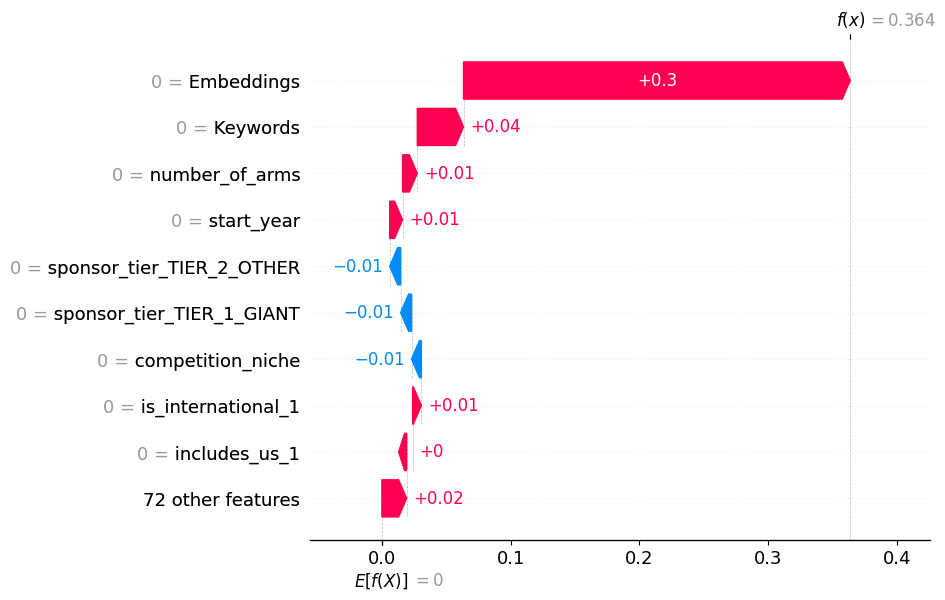

In [67]:
# --------------------------
# 17. Waterfall plot for the first patient
# --------------------------

# 1) Select sample
values = shap_agg_df.iloc[0].values
names  = shap_agg_df.columns.tolist()

# 2) Build Explanation object
expl = shap.Explanation(
    values=values,
    base_values=0,
    data=np.zeros_like(values),
    feature_names=names
)

# 3) Plot
shap.plots.waterfall(expl)

In [66]:
# --------------------------
# 18. Force plot for the first patient
# --------------------------
# 1) Select sample
values = shap_agg_df.iloc[0].values
names  = shap_agg_df.columns.tolist()

# 2) Build Explanation object
expl = shap.Explanation(
    values=values,
    base_values=0,
    data=np.zeros_like(values),
    feature_names=names
)

# 3) Plot
shap.plots.force(expl)

--- MODEL PERFORMANCE METRICS ---
ROC-AUC Score:      0.6927  (0.5 = Random, 1.0 = Perfect)
PR-AUC Score:       0.3274   (Baseline: 0.1841)
----------------------------------------
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.93      0.37      0.53     10993
           1       0.24      0.87      0.37      2480

    accuracy                           0.46     13473
   macro avg       0.58      0.62      0.45     13473
weighted avg       0.80      0.46      0.50     13473



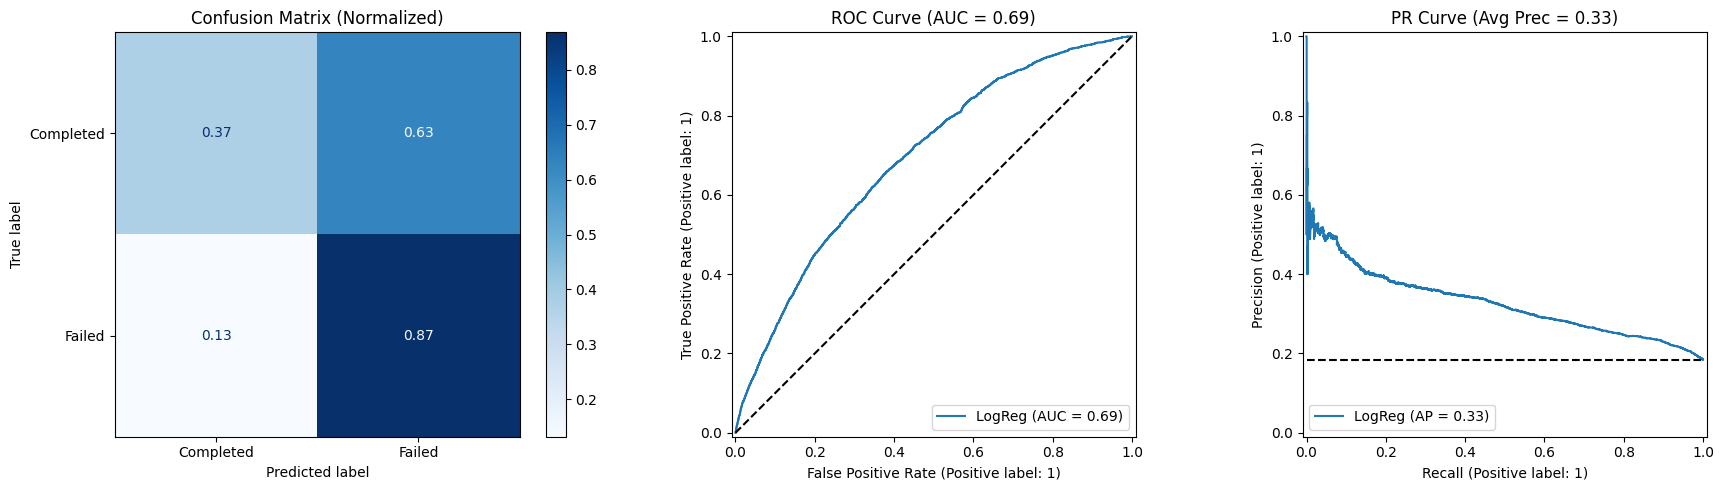

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay)

# 1. Get Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# 2. Calculate Advanced Metrics
roc_score = roc_auc_score(y_test, y_prob)
pr_score = average_precision_score(y_test, y_prob)

print(f"--- MODEL PERFORMANCE METRICS ---")
print(f"ROC-AUC Score:      {roc_score:.4f}  (0.5 = Random, 1.0 = Perfect)")
print(f"PR-AUC Score:       {pr_score:.4f}   (Baseline: {y_test.mean():.4f})")
print("-" * 40)
print("CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred))

# 3. Visualizations
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# A. Confusion Matrix (Normalized)
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    normalize='true',
    cmap='Blues',
    display_labels=['Completed', 'Failed'],
    ax=ax[0]
)
ax[0].set_title("Confusion Matrix (Normalized)")

# B. ROC Curve
RocCurveDisplay.from_predictions(y_test, y_prob, ax=ax[1], name='LogReg')
ax[1].set_title(f"ROC Curve (AUC = {roc_score:.2f})")
ax[1].plot([0, 1], [0, 1], "k--", label="Chance")

# C. Precision-Recall Curve
PrecisionRecallDisplay.from_predictions(y_test, y_prob, ax=ax[2], name='LogReg')
ax[2].set_title(f"PR Curve (Avg Prec = {pr_score:.2f})")
ax[2].plot([0, 1], [y_test.mean(), y_test.mean()], "k--", label="Baseline")

plt.tight_layout()
plt.show()